# Akari
---

<img src="../images/akari.png" style="width: 300px;">

In [68]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns 
import os

plt.rc('font', size=6)
sns.set()

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from dateutil.parser import parse

In [70]:
DATA_DIR = '../data/AAPL/prices.csv'

In [71]:
df = pd.read_csv(DATA_DIR)

In [72]:
df.head()

,Date,Close,Volume,Open,High,Low
0,1361923200000000000,15.8775,586219246,16.0154,16.1586,15.7375
1,1362009600000000000,15.7643,322049711,15.8589,15.9954,15.7643
2,1362096000000000000,15.3739,551278339,15.6429,15.6493,15.3564
3,1362355200000000000,15.0018,577328969,15.2786,15.2929,14.9643
4,1362441600000000000,15.3980,636908185,15.0529,15.5425,15.0268


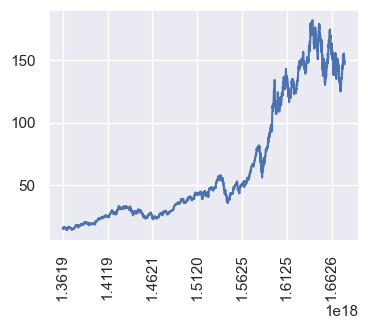

In [73]:
# Visualizing Closing Prices
fig = plt.figure(figsize=(4, 3))
plt.xticks(df['Date'][::400], rotation=90)
plt.plot(df['Date'], df['Close'])

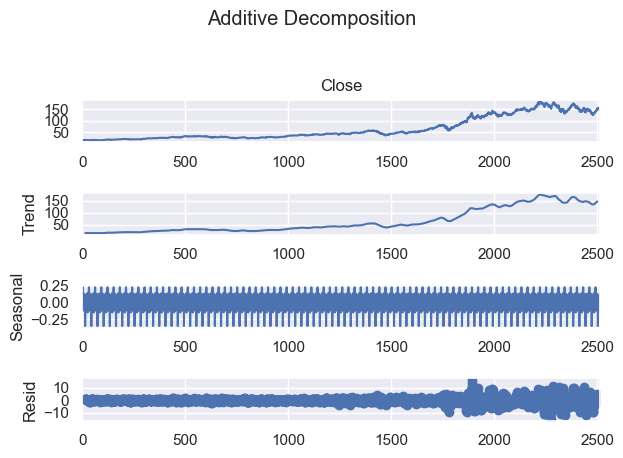

In [74]:
additive_decomposition = seasonal_decompose(df['Close'], model='additive', period=30)
additive_decomposition.plot().suptitle('Additive Decomposition')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

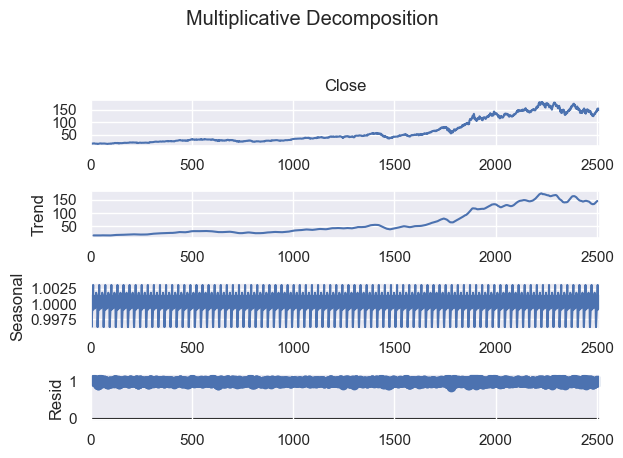

In [75]:
multiplicative_decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=30)
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [76]:
result = adfuller(df['Close'], autolag='AIC')
print(f'p-value: {result[1]}')

p-value: 0.9377053779705464


In [77]:
df['Close'].head()

0    15.8775
1    15.7643
2    15.3739
3    15.0018
4    15.3980
Name: Close, dtype: float64

In [78]:
# This is not so stationary
df_sqrt = np.sqrt(df['Close'])
df_sqrt = df_sqrt.diff().dropna()
df_sqrt.head()

1   -0.014230
2   -0.049472
3   -0.047741
4    0.050813
5   -0.025029
Name: Close, dtype: float64

In [79]:
result = adfuller(df_sqrt, autolag='AIC')
print(f'p-value: {result[1]}')

p-value: 2.7543446266176945e-18


<AxesSubplot: >

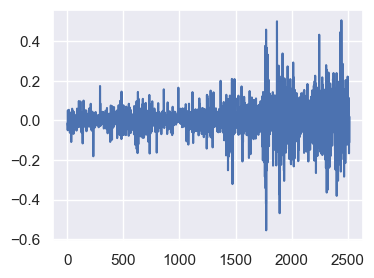

In [80]:
fig = plt.figure(figsize=(4, 3))
df_sqrt.plot()

In [81]:
df_sqrt.shape

(2516,)

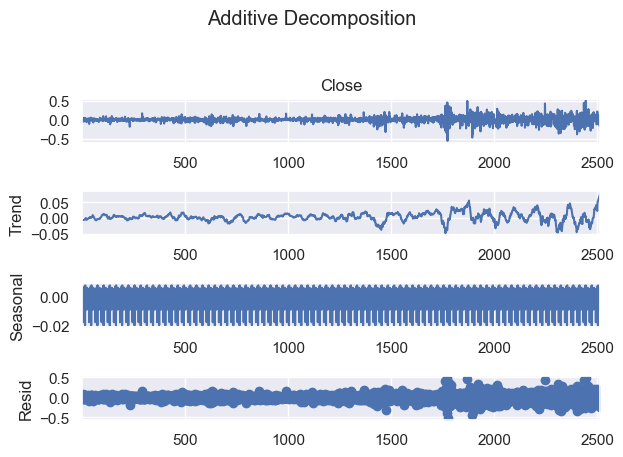

In [82]:
additive_decomposition = seasonal_decompose(df_sqrt, model='additive', period=30,  extrapolate_trend='freq')
additive_decomposition.plot().suptitle('Additive Decomposition')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [83]:
additive_decomposition.trend

1      -0.007416
2      -0.007198
3      -0.006981
4      -0.006763
5      -0.006545
          ...   
2512    0.070642
2513    0.072846
2514    0.075050
2515    0.077254
2516    0.079458
Name: trend, Length: 2516, dtype: float64

In [84]:
df_sqrt_detrended = df_sqrt.values - additive_decomposition.trend

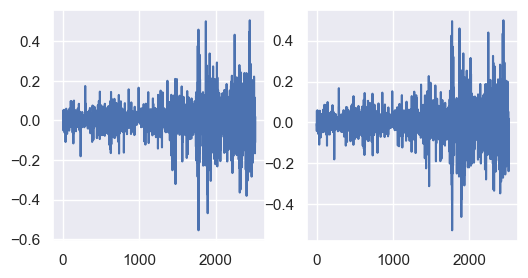

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.plot(df_sqrt)
ax2.plot(df_sqrt_detrended)

In [86]:
df_sqrt_detrended.values

array([-0.00681405, -0.04227345, -0.0407602 , ..., -0.05741871,
       -0.05719349, -0.18999717])

In [87]:
df_sqrt_detrended_deseasonalized = df_sqrt_detrended.values / additive_decomposition.seasonal

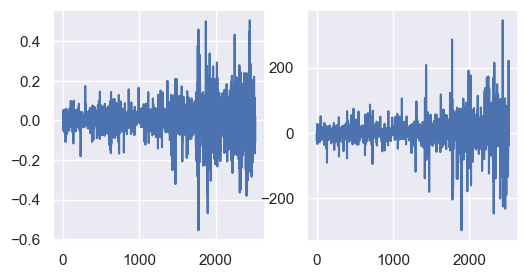

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.plot(df_sqrt)
ax2.plot(df_sqrt_detrended_deseasonalized)

In [89]:
new_df = df['Close']
print(new_df)

0        15.8775
1        15.7643
2        15.3739
3        15.0018
4        15.3980
          ...   
2512    152.5500
2513    148.4800
2514    148.9100
2515    149.4000
2516    146.7100
Name: Close, Length: 2517, dtype: float64


In [90]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [91]:
data_raw = new_df.values.reshape(-1, 1)

In [92]:
data_raw

array([[ 15.8775],
       [ 15.7643],
       [ 15.3739],
       ...,
       [148.91  ],
       [149.4   ],
       [146.71  ]])

In [93]:
scaler = MinMaxScaler(feature_range = (0, 1))

In [94]:
data_scaled = scaler.fit_transform(data_raw)

In [95]:
data_scaled

array([[0.01148382],
       [0.01081026],
       [0.00848732],
       ...,
       [0.80304946],
       [0.80596504],
       [0.78995909]])

In [96]:
data_scaled.shape

(2517, 1)

In [97]:
TRAIN_SIZE = 0.80

train_size = int(len(data_scaled) * TRAIN_SIZE)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]

print(f'Train size: {len(train)}')
print(f'Test size: {len(test)}')

Train size: 2013
Test size: 504


In [98]:
WINDOW_SIZE = 1

In [99]:
def create_dataset(dataset):
    data_X, data_Y = [], []
    for i in range(len(dataset) - WINDOW_SIZE):
        a = dataset[i:(i + WINDOW_SIZE), 0]
        data_X.append(a)
        data_Y.append(dataset[i + WINDOW_SIZE, 0])
    return(np.array(data_X), np.array(data_Y))

In [100]:
train_X, train_Y = create_dataset(train)
test_X, test_Y = create_dataset(test)
print(f'Initial training data shape: {train_X.shape}')

Initial training data shape: (2012, 1)


In [101]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print(f'Reshaped training data shape: {train_X.shape}')

Reshaped training data shape: (2012, 1, 1)


In [102]:
model = Sequential()

In [103]:
model.add(LSTM(128, return_sequences=True, input_shape= (1, WINDOW_SIZE)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 128)            66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [105]:
model.fit(train_X, train_Y, epochs=500, batch_size=32, verbose=2)

Epoch 1/500
63/63 - 4s - loss: 0.0152 - 4s/epoch - 70ms/step
Epoch 2/500
63/63 - 0s - loss: 1.4479e-04 - 287ms/epoch - 5ms/step
Epoch 3/500
63/63 - 0s - loss: 6.1142e-05 - 296ms/epoch - 5ms/step
Epoch 4/500
63/63 - 0s - loss: 5.9879e-05 - 340ms/epoch - 5ms/step
Epoch 5/500
63/63 - 0s - loss: 5.4700e-05 - 299ms/epoch - 5ms/step
Epoch 6/500
63/63 - 0s - loss: 5.2421e-05 - 278ms/epoch - 4ms/step
Epoch 7/500
63/63 - 0s - loss: 5.2267e-05 - 315ms/epoch - 5ms/step
Epoch 8/500
63/63 - 0s - loss: 4.9926e-05 - 341ms/epoch - 5ms/step
Epoch 9/500
63/63 - 0s - loss: 4.7524e-05 - 276ms/epoch - 4ms/step
Epoch 10/500
63/63 - 0s - loss: 4.7352e-05 - 276ms/epoch - 4ms/step
Epoch 11/500
63/63 - 0s - loss: 5.3267e-05 - 271ms/epoch - 4ms/step
Epoch 12/500
63/63 - 0s - loss: 5.1745e-05 - 273ms/epoch - 4ms/step
Epoch 13/500
63/63 - 0s - loss: 5.1133e-05 - 268ms/epoch - 4ms/step
Epoch 14/500
63/63 - 0s - loss: 4.9818e-05 - 273ms/epoch - 4ms/step
Epoch 15/500
63/63 - 0s - loss: 5.8578e-05 - 276ms/epoch - 4ms/

In [106]:
def predict_and_score(model, X, Y):
    pred_scaled = model.predict(X)
    pred = scaler.inverse_transform(pred_scaled)
    orig_data = scaler.inverse_transform([Y])
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred, pred_scaled)

In [107]:
rmse_train, train_predict, train_predict_scaled = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict, test_predict_scaled = predict_and_score(model, test_X, test_Y)

print(f"Training RMSE: {rmse_train} RMSE")
print(f"Test RMSE: {rmse_test} RMSE")

16/16 [==============================] - 0s 3ms/step
Training RMSE: 1.1925047302143894 RMSE
Test RMSE: 3.2193583998007327 RMSE


In [108]:
print(train_predict)

[[ 16.30246 ]
 [ 16.191454]
 [ 15.808781]
 ...
 [130.52608 ]
 [126.829834]
 [126.695564]]


In [109]:
print(scaler.inverse_transform([train_Y]))

[[ 15.7643  15.3739  15.0018 ... 126.     125.86   125.35  ]]


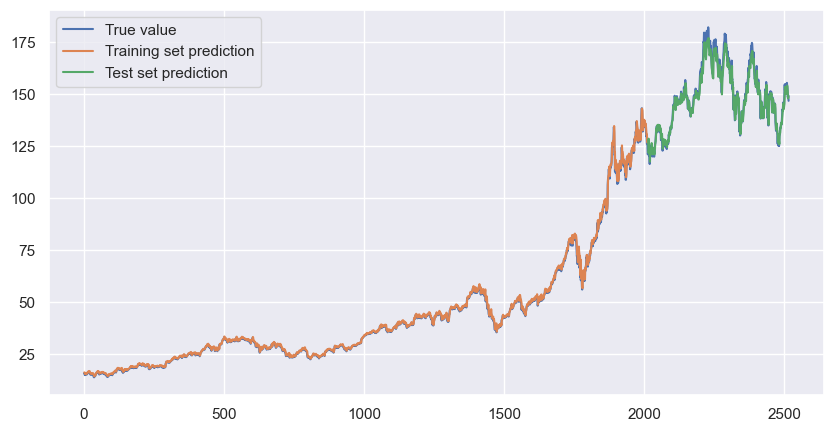

In [110]:
train_predict_plot = np.empty_like(data_scaled)
train_predict_plot[:, :] = np.nan
train_predict_plot[WINDOW_SIZE:len(train_predict) + WINDOW_SIZE, :] = train_predict
test_predict_plot = np.empty_like(data_scaled)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (WINDOW_SIZE * 2):len(data_scaled), :] = test_predict
plt.figure(figsize = (10, 5))
plt.plot(scaler.inverse_transform(data_scaled), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.legend()
plt.show()

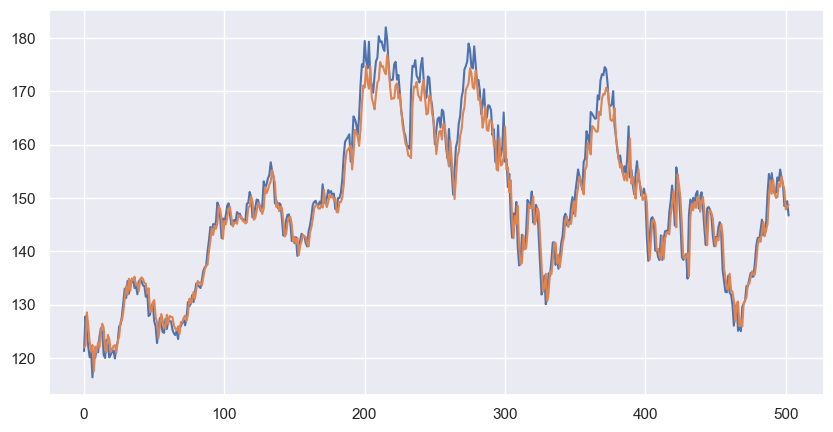

In [156]:
plt.figure(figsize=(10,5))
plt.plot(scaler.inverse_transform(test_Y.reshape(-1, 1)))
plt.plot(test_predict)

In [111]:
model.save(os.path.join('../models', 'akari_2.tflite'))

INFO:tensorflow:Assets written to: ../models\akari_1.tflite\assets


INFO:tensorflow:Assets written to: ../models\akari_1.tflite\assets


In [146]:
PREDICTIONS = 300

In [147]:
def predict(T, X):
    X_val=X.reshape(1, 1, WINDOW_SIZE)

    predictions = []

    for t in range(T):
        P = model.predict(X_val[-1].reshape(1, 1, WINDOW_SIZE))
        predictions.append(P[0][0])
        new_X_val = X_val[-1][0].reshape(WINDOW_SIZE)
        new_X_val = new_X_val[1:]
        P = P[0].reshape(1)
        new_X_val = np.concatenate((new_X_val, P), axis=0)
        X_val = np.concatenate((X_val, [[new_X_val]]))

    predictions = [predictions]
    predictions_scaled = scaler.inverse_transform(predictions)

    return predictions, predictions_scaled

In [148]:
predictions, predictions_scaled = predict(PREDICTIONS, test_X[-1])

1/1 [==============================] - 0s 27ms/step


In [149]:
print(predictions_scaled)

[[148.68591025 148.03754014 147.44773121 146.91033281 146.41993562
  145.9718415  145.56188327 145.18639459 144.84212984 144.52617401
  144.23600272 143.9692619  143.72390804 143.49806788 143.29002848
  143.09830727 142.92157194 142.75854029 142.60809038 142.46919042
  142.34092884 142.2224141  142.11292495 142.01170007 141.91810839
  141.83154885 141.75149054 141.67741257 141.60884411 141.54538448
  141.48663298 141.43223901 141.381872   141.33521139 141.29199673
  141.25196758 141.21488352 141.18052416 141.14867914 141.11917818
  141.09183093 141.06649717 141.04300659 141.02122896 141.00103408
  140.98232175 140.96497178 140.94890402 140.93397823 140.92015435
  140.90734222 140.89546169 140.88443264 140.87421499 140.86473862
  140.85594342 140.84778933 140.84022627 140.83321415 140.82669289
  140.82065245 140.81505278 140.80984378 140.80503547 140.80057777
  140.79643061 140.79259398 140.78902782 140.78573213 140.78267685
  140.77984195 140.77719738 140.77475316 140.77247923 140.7703

In [150]:
print(scaler.inverse_transform(test_Y.reshape(-1, 1)))

[[121.26 ]
 [127.79 ]
 [125.12 ]
 [122.06 ]
 [120.13 ]
 [121.42 ]
 [116.36 ]
 [121.085]
 [119.98 ]
 [121.96 ]
 [121.03 ]
 [123.99 ]
 [125.57 ]
 [124.76 ]
 [120.53 ]
 [119.99 ]
 [123.39 ]
 [122.54 ]
 [120.09 ]
 [120.59 ]
 [121.21 ]
 [121.39 ]
 [119.9  ]
 [122.15 ]
 [123.   ]
 [125.9  ]
 [126.21 ]
 [127.9  ]
 [130.36 ]
 [132.995]
 [131.24 ]
 [134.43 ]
 [132.03 ]
 [134.5  ]
 [134.16 ]
 [134.84 ]
 [133.11 ]
 [133.5  ]
 [131.94 ]
 [134.32 ]
 [134.72 ]
 [134.39 ]
 [133.58 ]
 [133.48 ]
 [131.46 ]
 [132.54 ]
 [127.85 ]
 [128.1  ]
 [129.74 ]
 [130.21 ]
 [126.85 ]
 [125.91 ]
 [122.77 ]
 [124.97 ]
 [127.45 ]
 [126.27 ]
 [124.85 ]
 [124.69 ]
 [127.31 ]
 [125.43 ]
 [127.1  ]
 [126.9  ]
 [126.85 ]
 [125.28 ]
 [124.61 ]
 [124.28 ]
 [125.06 ]
 [123.54 ]
 [125.89 ]
 [125.9  ]
 [126.74 ]
 [127.13 ]
 [126.11 ]
 [127.35 ]
 [130.48 ]
 [129.64 ]
 [130.15 ]
 [131.79 ]
 [130.46 ]
 [132.3  ]
 [133.98 ]
 [133.7  ]
 [133.41 ]
 [133.11 ]
 [134.78 ]
 [136.33 ]
 [136.96 ]
 [137.27 ]
 [139.96 ]
 [142.02 ]
 [144.57 ]

In [151]:
data_scaled

array([[0.01148382],
       [0.01081026],
       [0.00848732],
       ...,
       [0.80304946],
       [0.80596504],
       [0.78995909]])

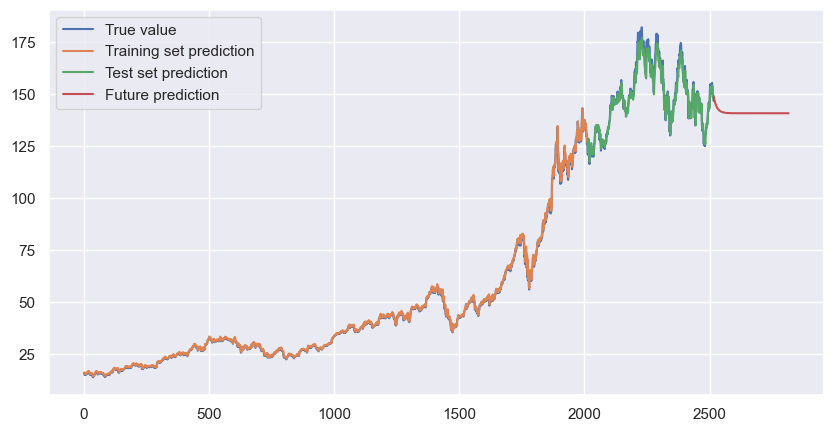

In [153]:
train_predict_plot = np.full(len(data_scaled) + PREDICTIONS, np.nan).reshape(-1, 1)
train_predict_plot[:, :] = np.nan
train_predict_plot[WINDOW_SIZE:len(train_predict) + WINDOW_SIZE, :] = train_predict
test_predict_plot = np.full(len(data_scaled) + PREDICTIONS, np.nan).reshape(-1, 1)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (WINDOW_SIZE * 2):len(data_scaled), :] = test_predict
future_predict_plot = np.full(len(data_scaled) + PREDICTIONS, np.nan).reshape(-1, 1)
future_predict_plot[:, :] = np.nan
future_predict_plot[len(data_scaled):len(data_scaled) + PREDICTIONS, :] = predictions_scaled.reshape(PREDICTIONS, 1)
plt.figure(figsize = (10, 5))
plt.plot(scaler.inverse_transform(data_scaled), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.plot(future_predict_plot, label = "Future prediction")
plt.legend()
plt.show()